# Hands-on 2: How to create a fMRI analysis workflow

The purpose of this section is that you set up a complete fMRI analysis workflow yourself. So that in the end, you are able to perform the analysis from A-Z, i.e. from preprocessing to group analysis. This section will cover the analysis part, the previous section [Hands-on 1: Preprocessing](handson_preprocessing.ipynb) handles the preprocessing part.

We will use this opportunity to show you some nice additional interfaces/nodes that might not be relevant to your usual analysis. But it's always nice to know that they exist. And hopefully, this will encourage you to investigate all other interfaces that Nipype can bring to the tip of your finger.

<span style="color:red">Important</span>: You will not be able to go through this notebook if you haven't preprocessed your subjects first.

# 1st-level Analysis Workflow Structure

In this notebook, we will create a workflow that performs 1st-level analysis and normalizes the resulting beta weights to the MNI template. In concrete steps this means:

    1. Specify 1st-level model parameters
    2. Specify 1st-level contrasts
    3. Estimate 1st-level contrasts
    4. Normalize 1st-level contrasts

## Imports

It's always best to have all relevant module imports at the beginning of your script. So let's import what we most certainly need.

In [1]:
from nilearn import plotting
%matplotlib inline

# Get the Node and Workflow object
from nipype import Node, Workflow

# Specify which SPM to use
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12-r7219/spm12_mcr/spm12')

/opt/miniconda-latest/envs/neuro/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


211108-07:19:33,658 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.6.1


**Note:** Ideally you would also put the imports of all the interfaces that you use here at the top. But as we will develop the workflow step by step, we can also import the relevant modules as we go.

## Create Nodes and Workflow connections

Let's create all the nodes that we need! Make sure to specify all relevant inputs and keep in mind which ones you later on need to connect in your pipeline.

### Workflow for the 1st-level analysis

We recommend to create the workflow and establish all its connections at a later place in your script. This helps to have everything nicely together. But for this hands-on example, it makes sense to establish the connections between the nodes as we go.

And for this, we first need to create a workflow:

In [43]:
analysis1st = Workflow(name='work_1st', base_dir='/home/neuro/Result/Nipype_tutorial/working_dir/')

### Specify 1st-level model parameters (stimuli onsets, duration, etc.)

The specify the 1st-level model we need the subject-specific onset times and duration of the stimuli. Luckily, as we are working with a BIDS dataset, this information is nicely stored in a `tsv` file:

In [44]:
import pandas as pd
trialinfo = pd.read_table('/home/neuro/Data/ds000114/task-fingerfootlips_events.tsv')
trialinfo

,onset,duration,weight,trial_type
0,10,15.0,1,Finger
1,40,15.0,1,Foot
2,70,15.0,1,Lips
3,100,15.0,1,Finger
4,130,15.0,1,Foot
5,160,15.0,1,Lips
6,190,15.0,1,Finger
7,220,15.0,1,Foot
8,250,15.0,1,Lips
9,280,15.0,1,Finger


Using pandas is probably the quickest and easiest ways to aggregate stimuli information per condition.

In [45]:
for group in trialinfo.groupby('trial_type'):
    print(group)
    print("")

('Finger',     onset  duration  weight trial_type
0      10      15.0       1     Finger
3     100      15.0       1     Finger
6     190      15.0       1     Finger
9     280      15.0       1     Finger
12    370      15.0       1     Finger)

('Foot',     onset  duration  weight trial_type
1      40      15.0       1       Foot
4     130      15.0       1       Foot
7     220      15.0       1       Foot
10    310      15.0       1       Foot
13    400      15.0       1       Foot)

('Lips',     onset  duration  weight trial_type
2      70      15.0       1       Lips
5     160      15.0       1       Lips
8     250      15.0       1       Lips
11    340      15.0       1       Lips
14    430      15.0       1       Lips)



To create a GLM model, Nipype needs an list of `Bunch` objects per session. As we only have one session, our object needs to look as follows:

    [Bunch(conditions=['Finger', 'Foot', 'Lips'],
           durations=[[15.0, 15.0, 15.0, 15.0, 15.0],
                      [15.0, 15.0, 15.0, 15.0, 15.0],
                      [15.0, 15.0, 15.0, 15.0, 15.0]],
           onsets=[[10, 100, 190, 280, 370],
                   [40, 130, 220, 310, 400],
                   [70, 160, 250, 340, 430]]
           )]

For more information see either the [official documnetation](http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.algorithms.modelgen.html) or the [nipype_tutorial example](https://miykael.github.io/nipype_tutorial/notebooks/example_1stlevel.html#Specify-GLM-Model).

So, let's create this Bunch object that we then can use for the GLM model.

In [46]:
import pandas as pd
from nipype.interfaces.base import Bunch

trialinfo = pd.read_table('/home/neuro/Data/ds000114/task-fingerfootlips_events.tsv')
conditions = []
onsets = []
durations = []

for group in trialinfo.groupby('trial_type'):
    conditions.append(group[0])
    onsets.append(list(group[1].onset -10)) # subtracting 10s due to removing of 4 dummy scans
    durations.append(group[1].duration.tolist())

subject_info = [Bunch(conditions=conditions,
                      onsets=onsets,
                      durations=durations,
                      )]
subject_info

[Bunch(conditions=['Finger', 'Foot', 'Lips'],
       durations=[[15.0, 15.0, 15.0, 15.0, 15.0],
        [15.0, 15.0, 15.0, 15.0, 15.0],
        [15.0, 15.0, 15.0, 15.0, 15.0]],
       onsets=[[0, 90, 180, 270, 360],
        [30, 120, 210, 300, 390],
        [60, 150, 240, 330, 420]])]

Good! Now we can create the node that will create the SPM model. For this we will be using `SpecifySPMModel`. As a reminder the TR of the acquisition is 2.5s and we want to use a high pass filter of 128.

In [47]:
from nipype.algorithms.modelgen import SpecifySPMModel

In [48]:
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=2.5,
                                 high_pass_filter_cutoff=128,
                                 subject_info=subject_info),
                 name="modelspec")

This node will also need some additional inputs, such as the preprocessed functional images, the motion parameters etc. We will specify those once we take care of the workflow data input stream.

### Specify 1st-level contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate. If we recap, we had three different conditions in the **fingerfootlips** task in this dataset:

- **finger**
- **foot**
- **lips**

Therefore, we could create the following contrasts (seven T-contrasts and two F-contrasts):

In [49]:
# Condition names
condition_names = ['Finger', 'Foot', 'Lips']

# Contrasts
cont01 = ['average',        'T', condition_names, [1/3., 1/3., 1/3.]]
cont02 = ['Finger',         'T', condition_names, [1, 0, 0]]
cont03 = ['Foot',           'T', condition_names, [0, 1, 0]]
cont04 = ['Lips',           'T', condition_names, [0, 0, 1]]
cont05 = ['Finger < others','T', condition_names, [-1, 0.5, 0.5]]
cont06 = ['Foot < others',  'T', condition_names, [0.5, -1, 0.5]]
cont07 = ['Lips > others',  'T', condition_names, [-0.5, -0.5, 1]]

cont08 = ['activation',     'F', [cont02, cont03, cont04]]
cont09 = ['differences',    'F', [cont05, cont06, cont07]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09]

### Estimate 1st-level contrasts

Before we can estimate the 1st-level contrasts, we first need to create the 1st-level design. Here you can also specify what kind of basis function you want (HRF, FIR, Fourier, etc.), if you want to use time and dispersion derivatives and how you want to model the serial correlation.

In this example, I propose that you use an HRF basis function, that we model time derivatives and that we model the serial correlation with AR(1).

In [50]:
from nipype.interfaces.spm import Level1Design

In [51]:
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=2.5,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

Now that we have the Model Specification and 1st-Level Design node, we can connect them to each other:

In [52]:
analysis1st.connect([(modelspec, level1design, [('session_info',
                                                 'session_info')])])

Now we need to estimate the model. I recommend that you'll use a `Classical: 1` method to estimate the model.

In [53]:
from nipype.interfaces.spm import EstimateModel

In [13]:
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

Now we can connect the 1st-Level Design node with the model estimation node.

In [55]:
analysis1st.connect([(level1design, level1estimate, [('spm_mat_file',
                                                      'spm_mat_file')])])

Now that we estimate the model, we can estimate the contrasts. Don't forget to feed the list of contrast we specify above to this node.

In [15]:
from nipype.interfaces.spm import EstimateContrast

In [16]:
level1conest = Node(EstimateContrast(contrasts=contrast_list),
                    name="level1conest")

Now we can connect the model estimation node with the contrast estimation node.

In [57]:
analysis1st.connect([(level1estimate, level1conest, [('spm_mat_file',
                                                      'spm_mat_file'),
                                                     ('beta_images',
                                                      'beta_images'),
                                                     ('residual_image',
                                                      'residual_image')])])

### Normalize 1st-level contrasts

Now that the contrasts were estimated in subject space we can put them into a common reference space by normalizing them to a specific template. In this case, we will be using SPM12's Normalize routine and normalize to the SPM12 tissue probability map `TPM.nii`.

At this step, you can also specify the voxel resolution of the output volumes. If you don't specify it, it will normalize to a voxel resolution of 2x2x2mm. As a training exercise, set the voxel resolution to 4x4x4mm.

In [58]:
from nipype.interfaces.spm import Normalize12

# Location of the template
template = '/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii'

In [59]:
normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=template,
                             write_voxel_sizes=[4, 4, 4]
                            ),
                 name="normalize")

Now we can connect the estimated contrasts to normalization node.

In [60]:
analysis1st.connect([(level1conest, normalize, [('con_images',
                                                 'apply_to_files')])
                     ])

## Datainput with `SelectFiles` and `iterables` 

As in the preprocessing hands-on, we will again be using [`SelectFiles`](../../../nipype_tutorial/notebooks/basic_data_input.ipynb#SelectFiles) and [`iterables`](../../../nipype_tutorial/notebooks/basic_iteration.ipynb). So, what do we need?

From the preprocessing pipeline, we need the functional images, the motion parameters and the list of outliers. Also, for the normalization, we need the subject-specific anatomy.

In [61]:
# Import the SelectFiles
from nipype import SelectFiles

# String template with {}-based strings
templates = {'anat': '/home/neuro/Data/ds000114/sub-{subj_id}/ses-test/anat/sub-{subj_id}_ses-test_T1w.nii.gz',
             'func': '/home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/preproc/sub-{subj_id}_detrend.nii.gz',
             'mc_param': '/home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/preproc/sub-{subj_id}.par',
             'outliers': '/home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/preproc/art.sub-{subj_id}_outliers.txt'
            }

# Create SelectFiles node
sf = Node(SelectFiles(templates, sort_filelist=True),
          name='selectfiles')

Now we can specify over which subjects the workflow should iterate. As we preprocessed only subjects 1 to 5, we can only them for this analysis.

In [62]:
# list of subject identifiers
subject_list = ['02', '03', '04', '07', '08', '09']
sf.iterables = [('subj_id', subject_list)]

### Gunzip Node

SPM12 can accept NIfTI files as input, but online if they are not compressed ('unzipped'). Therefore, we need to use a `Gunzip` node to unzip the detrend file and another one to unzip the anatomy image, before we can feed it to the model specification node.

In [63]:
from nipype.algorithms.misc import Gunzip

In [64]:
gunzip_anat = Node(Gunzip(), name='gunzip_anat')
gunzip_func = Node(Gunzip(), name='gunzip_func')

And as a final step, we just need to connect this `SelectFiles` node to the rest of the workflow.

In [65]:
analysis1st.connect([(sf, gunzip_anat, [('anat', 'in_file')]),
                     (sf, gunzip_func, [('func', 'in_file')]),
                     (gunzip_anat, normalize, [('out_file', 'image_to_align')]),
                     (gunzip_func, modelspec, [('out_file', 'functional_runs')]),
                     (sf, modelspec, [('mc_param', 'realignment_parameters'),
                                      ('outliers', 'outlier_files')])
                    ])

## Data output with `DataSink`

Now, before we run the workflow, let's again specify a `Datasink` folder to only keep those files that we want to keep.

In [26]:
from nipype.interfaces.io import DataSink

In [66]:
# Initiate the datasink node
output_folder = 'datasink_handson'
datasink = Node(DataSink(base_directory='/home/neuro/Result/Nipype_tutorial/working_dir',
                         container=output_folder),
                name="datasink")

In [67]:
## Use the following substitutions for the DataSink output
substitutions = [('_subj_id_', 'sub-')]
datasink.inputs.substitutions = substitutions

Now the next step is to specify all the output that we want to keep in our output folder `output`. Probably best to keep are the:
- SPM.mat file and the spmT and spmF files from the contrast estimation node
- normalized betas and anatomy

In [68]:
analysis1st.connect([(level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                               ('spmT_images', '1stLevel.@T'),
                                               ('spmF_images', '1stLevel.@F'),
                                              ]),
                     (normalize, datasink, [('normalized_files', 'normalized.@files'),
                                            ('normalized_image', 'normalized.@image'),
                                           ]),
                    ])

## Visualize the workflow

Now that the workflow is finished, let's visualize it again.

211108-11:40:30,616 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Nipype_tutorial/working_dir/work_1st/graph.png (graph2use=flat, simple_form=True).


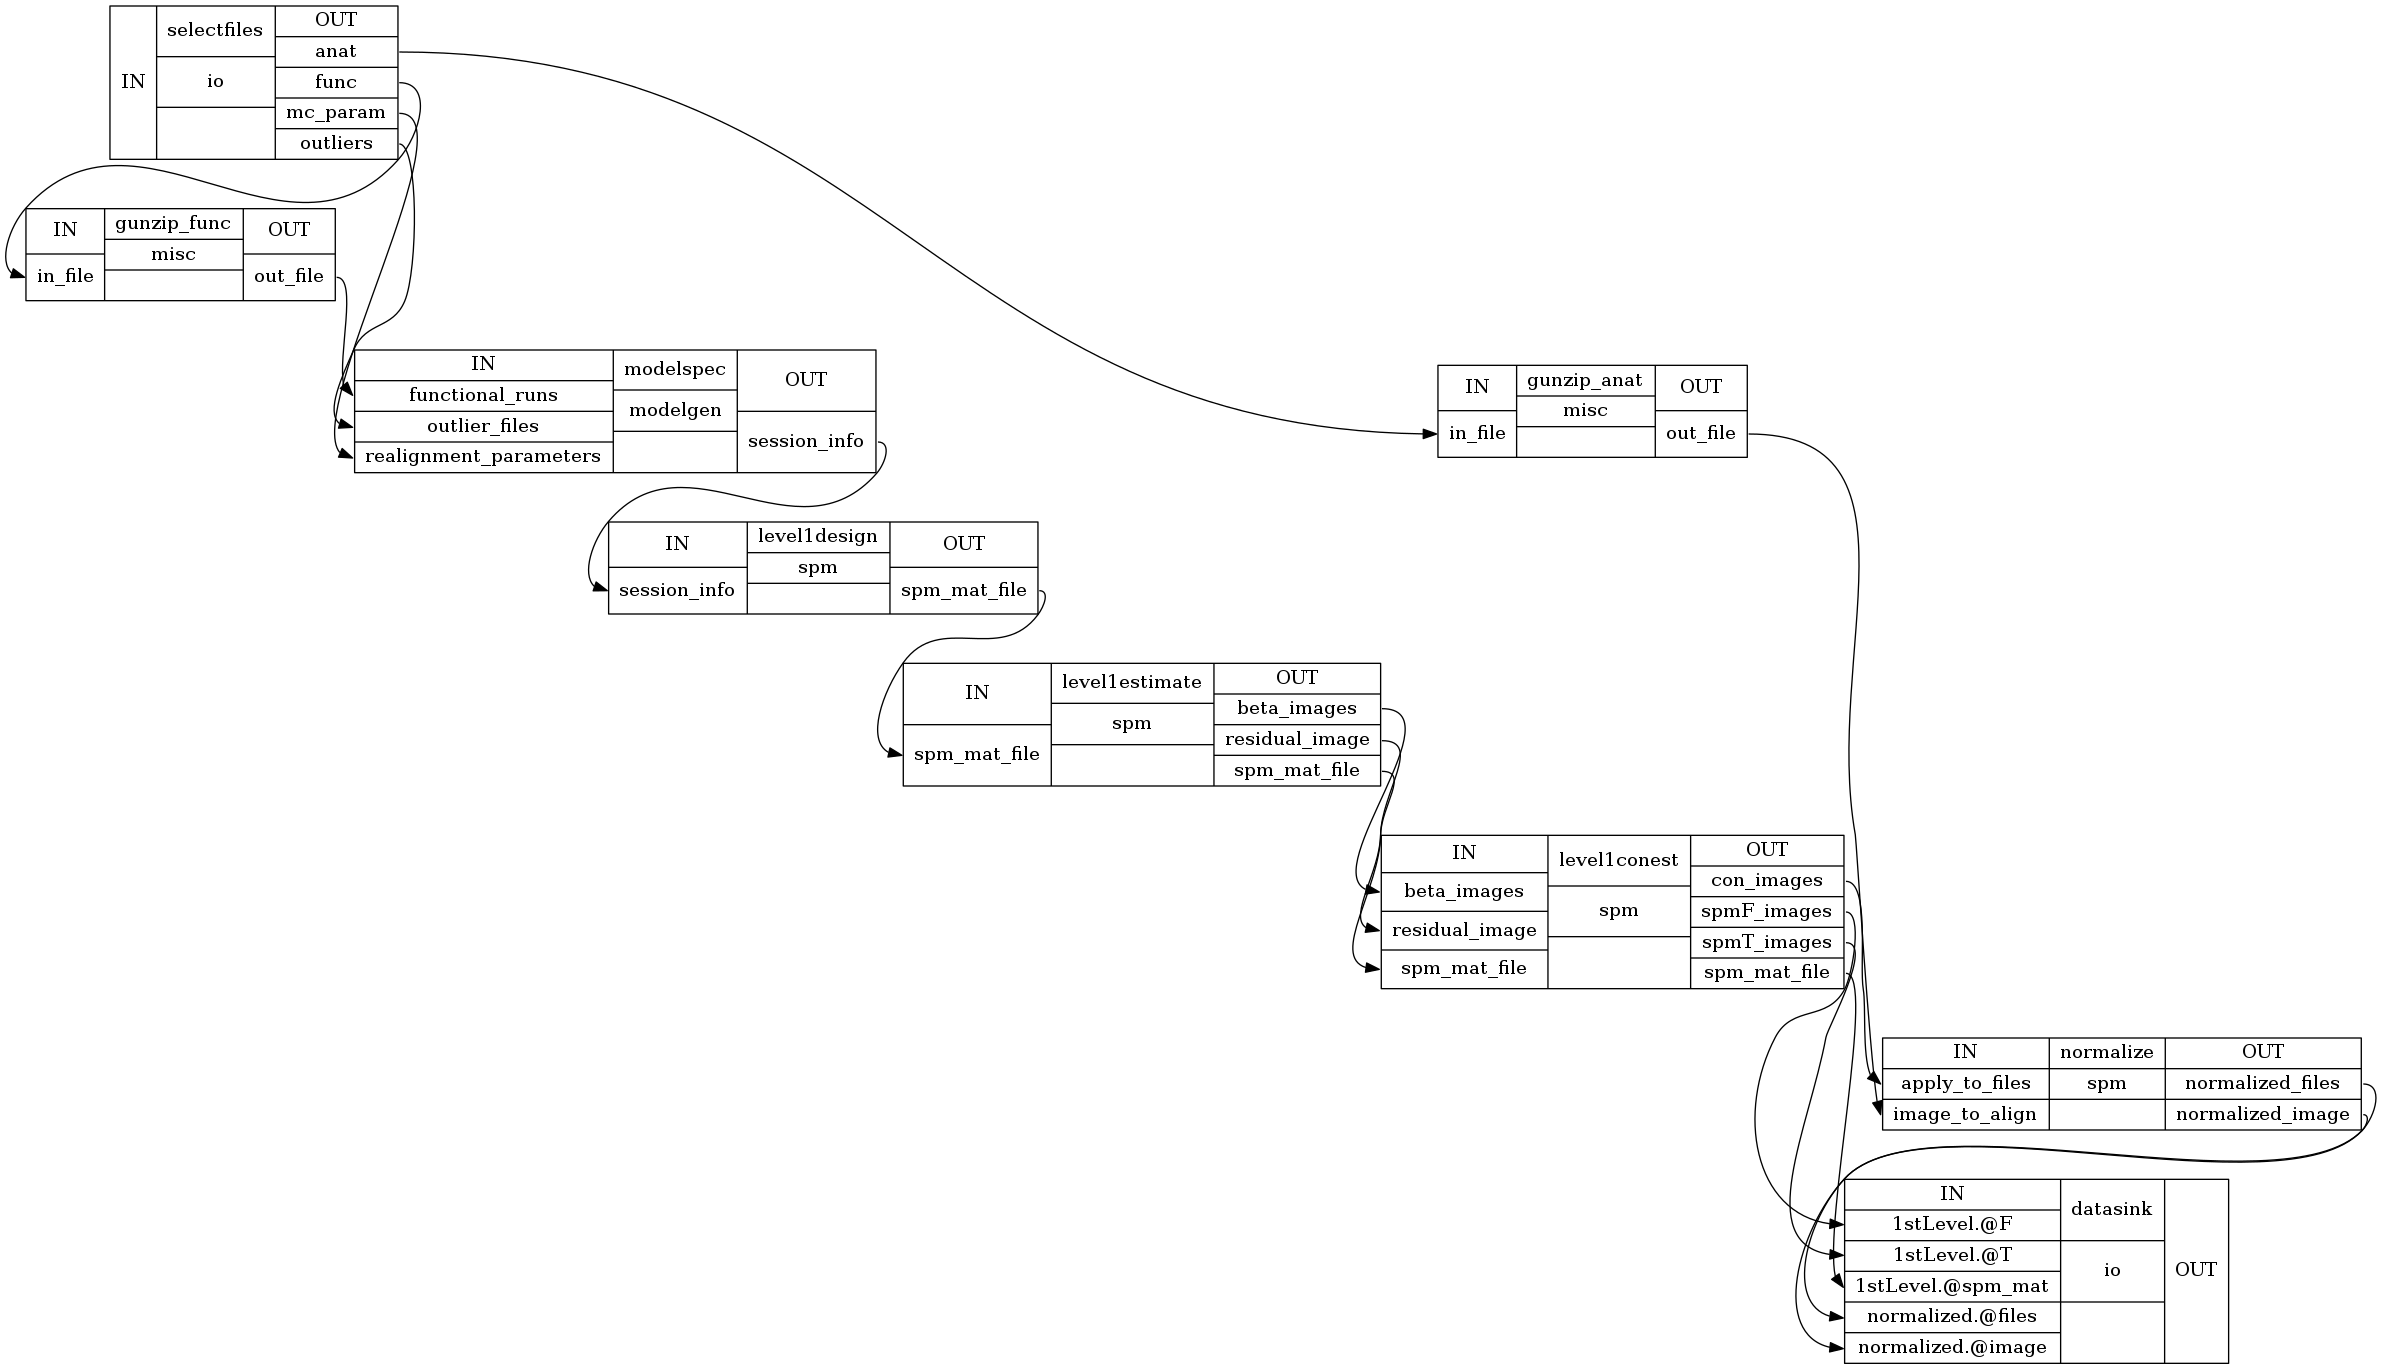

In [71]:
# Create 1st-level analysis output graph
analysis1st.write_graph(graph2use='flat', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename='/home/neuro/Result/Nipype_tutorial/working_dir/work_1st/graph_detailed.png')

##  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [74]:
analysis1st.run('MultiProc', plugin_args={'n_procs': 4})

211108-11:58:19,225 nipype.workflow INFO:
	 Workflow work_1st settings: ['check', 'execution', 'logging', 'monitoring']
211108-11:58:19,290 nipype.workflow INFO:
	 Running in parallel.
211108-11:58:19,293 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211108-11:58:19,390 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_1st/_subj_id_09/selectfiles".
211108-11:58:19,396 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_1st/_subj_id_08/selectfiles".
211108-11:58:19,400 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_1st/_subj_id_07/selectfiles".
211108-11:58:19,404 nipype.workflow INFO:
	 [Node] Setting-up "work_1st.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_1st/_subj_id_04/sel

## Visualize results

In [75]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

First, let's look at the 1st-level Design Matrix of subject one, to verify that everything is as it should be.

In [76]:
from scipy.io import loadmat

# Using scipy's loadmat function we can access SPM.mat
spmmat = loadmat('/home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/1stLevel/sub-07/SPM.mat',
                 struct_as_record=False)

The design matrix and the names of the regressors are a bit hidden in the `spmmat` variable, but they can be accessed as follows:

In [80]:
designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]

Now before we can plot it, we just need to normalize the desing matrix in such a way, that each column has a maximum amplitude of 1. This is just for visualization purposes, otherwise the rotation parameters with their rather small values will not show up in the figure.

In [81]:
normed_design = designMatrix / np.abs(designMatrix).max(axis=0)

And we're ready to plot the design matrix.

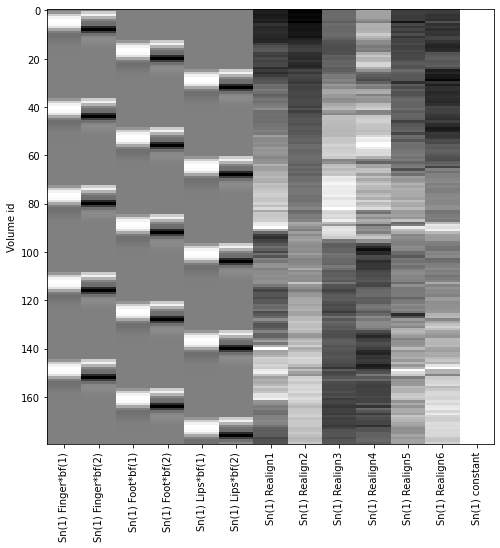

In [79]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
ax.set_ylabel('Volume id')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90);

Now that we're happy with the design matrix, let's look how well the normalization worked.

In [82]:
import nibabel as nb
from nilearn.plotting import plot_anat
from nilearn.plotting import plot_glass_brain

/tmp/ipykernel_2122/902460378.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  GM_template = nb.Nifti1Image(img.get_data()[..., 0], img.affine, img.header)


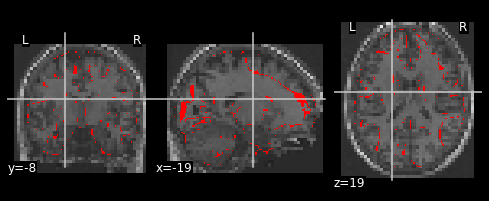

In [86]:
# Load GM probability map of TPM.nii
img = nb.load('/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii')
GM_template = nb.Nifti1Image(img.get_data()[..., 0], img.affine, img.header)

# Plot normalized subject anatomy
display = plot_anat('/home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/normalized/sub-07/wsub-07_ses-test_T1w.nii',
                    dim=-0.1)

# Overlay in edges GM map
display.add_edges(GM_template)

Let's look at the contrasts of one subject that we've just computed. In particular the F-contrast.

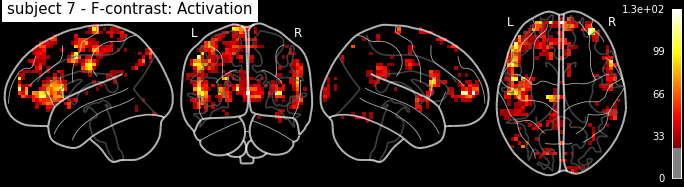

In [87]:
plot_glass_brain('/home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/normalized/sub-07/wess_0008.nii',
                 output_file="/home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/normalized/sub-07/f-contr_activation.png",
                 colorbar=True, display_mode='lyrz', black_bg=True, threshold=25,
                 title='subject 7 - F-contrast: Activation');

Image(filename='/home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/normalized/sub-07/f-contr_activation.png')

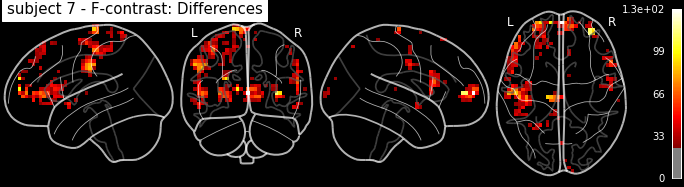

In [88]:
plot_glass_brain('/home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/normalized/sub-07/wess_0009.nii',
                 output_file="/home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/normalized/sub-07/f-contr_differences.png",
                 colorbar=True, display_mode='lyrz', black_bg=True, threshold=25,
                 title='subject 7 - F-contrast: Differences');

Image(filename='/home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/normalized/sub-07/f-contr_differences.png')

# 2nd-level Analysis Workflow Structure

Last but not least, the group level analysis. This example will also directly include thresholding of the output, as well as some visualization.

## Imports

To make sure that the necessary imports are done, here they are again:

In [89]:
# Get the Node and Workflow object
from nipype import Node, Workflow

# Specify which SPM to use
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12-r7219/spm12_mcr/spm12')

## Create Nodes and Workflow connections

Now we should know this part very well.

### Workflow for the 2nd-level analysis

In [90]:
analysis2nd = Workflow(name='work_2nd', base_dir='/home/neuro/Result/Nipype_tutorial/working_dir/')

## 2nd-Level Design

This step depends on your study design and the tests you want to perform. If you're using SPM to do the group analysis, you have the liberty to choose between a factorial design, a multiple regression design, one-sample T-Test design, a paired T-Test design or a two-sample T-Test design.

For the current example, we will be using a one sample T-Test design.

In [91]:
from nipype.interfaces.spm import OneSampleTTestDesign

In [92]:
onesamplettestdes = Node(OneSampleTTestDesign(), name="onesampttestdes")

The next two steps are the same as for the 1st-level design, i.e. estimation of the model followed by estimation of the contrasts.

In [93]:
from nipype.interfaces.spm import EstimateModel, EstimateContrast

In [94]:
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")

To finish the `EstimateContrast` node, we also need to specify which contrast should be computed. For a 2nd-level one sample t-test design, this is rather straightforward:

In [95]:
cont01 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont01]

Now, let's connect those three design nodes to each other.

In [96]:
analysis2nd.connect([(onesamplettestdes, level2estimate, [('spm_mat_file',
                                                           'spm_mat_file')]),
                     (level2estimate, level2conestimate, [('spm_mat_file',
                                                           'spm_mat_file'),
                                                          ('beta_images',
                                                           'beta_images'),
                                                          ('residual_image',
                                                           'residual_image')])
                    ])

## Thresholding of output contrast

And to close, we will use SPM `Threshold`. With this routine, we can set a specific voxel threshold (i.e. *p*<0.001) and apply an FDR cluster threshold (i.e. *p*<0.05).

As we only have 5 subjects, I recommend to set the voxel threshold to 0.01 and to leave the cluster threshold at 0.05.

In [97]:
from nipype.interfaces.spm import Threshold

In [98]:
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.01,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

In [99]:
analysis2nd.connect([(level2conestimate, level2thresh, [('spm_mat_file',
                                                         'spm_mat_file'),
                                                        ('spmT_images',
                                                         'stat_image'),
                                                       ])
                    ])

## Gray Matter Mask

We could run our 2nd-level workflow as it is. All the major nodes are there. But I nonetheless suggest that we use a gray matter mask to restrict the analysis to only gray matter voxels.

In the 1st-level analysis, we normalized to SPM12's `TPM.nii` tissue probability atlas. Therefore, we could just take the gray matter probability map of this `TPM.nii` image (the first volume) and threshold it at a certain probability value to get a binary mask. This can of course also all be done in Nipype, but sometimes the direct bash code is quicker:

In [100]:
%%bash
TEMPLATE='/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii'

# Extract the first volume with `fslroi`
fslroi $TEMPLATE GM_PM.nii.gz 0 1

# Threshold the probability mask at 10%
fslmaths GM_PM.nii -thr 0.10 -bin /home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/GM_mask.nii.gz

# Unzip the mask and delete the GM_PM.nii file
gunzip /home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/GM_mask.nii.gz
rm GM_PM.nii.gz

Let's take a look at this mask:

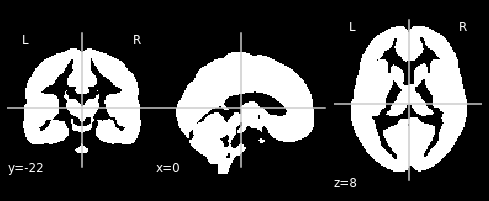

In [101]:
from nilearn.plotting import plot_anat
%matplotlib inline
plot_anat('/home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/GM_mask.nii', dim=-1)

Now we just need to specify this binary mask as an `explicit_mask_file` for the one sample T-test node.

In [102]:
onesamplettestdes.inputs.explicit_mask_file = '/home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/GM_mask.nii'

## Datainput with `SelectFiles` and `iterables` 

We will again be using [`SelectFiles`](../../../nipype_tutorial/notebooks/basic_data_input.ipynb#SelectFiles) and [`iterables`](../../../nipype_tutorial/notebooks/basic_iteration.ipynb).

So, what do we need? Actually, just the 1st-level contrasts of all subjects, separated by contrast number.

In [103]:
# Import the SelectFiles
from nipype import SelectFiles

# String template with {}-based strings
templates = {'cons': '/home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/normalized/sub-*/w*_{cont_id}.nii'}

# Create SelectFiles node
sf = Node(SelectFiles(templates, sort_filelist=True),
          name='selectfiles')

We are using `*` to tell `SelectFiles` that it can grab all available subjects and any contrast, with a specific contrast id, independnet if it's an t-contrast (`con`) or an F-contrast (`ess`) contrast.

So, let's specify over which contrast the workflow should iterate.

In [107]:
# list of contrast identifiers
contrast_id_list = ['0001', '0002', '0003', '0004', '0005',
                    '0006', '0007', '0008', '0009']
sf.iterables = [('cont_id', contrast_id_list)]

Now we need to connect the `SelectFiles` to the `OneSampleTTestDesign` node.

In [106]:
analysis2nd.connect([(sf, onesamplettestdes, [('cons', 'in_files')])])

Exception: Trying to connect work_2nd.selectfiles:cons to work_2nd.onesampttestdes:in_files but input 'in_files' of node 'work_2nd.onesampttestdes' is already
connected.


## Data output with `DataSink`

Now, before we run the workflow, let's again specify a `Datasink` folder to only keep those files that we want to keep.

In [108]:
from nipype.interfaces.io import DataSink

In [ ]:
# Initiate DataSink node here

In [109]:
# Initiate the datasink node
output_folder = 'datasink_handson'
datasink = Node(DataSink(base_directory='/home/neuro/Result/Nipype_tutorial/working_dir/',
                         container=output_folder),
                name="datasink")

In [110]:
## Use the following substitutions for the DataSink output
substitutions = [('_cont_id_', 'con_')]
datasink.inputs.substitutions = substitutions

Now the next step is to specify all the output that we want to keep in our output folder `output`. Probably best to keep are the:
- the SPM.mat file and the spmT images from the `EstimateContrast` node
- the thresholded spmT images from the `Threshold` node

In [111]:
analysis2nd.connect([(level2conestimate, datasink, [('spm_mat_file',
                                                     '2ndLevel.@spm_mat'),
                                                    ('spmT_images',
                                                     '2ndLevel.@T'),
                                                    ('con_images',
                                                     '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')])
                     ])

## Visualize the workflow

And we're good to go. Let's first take a look at the workflow.

211108-12:26:38,281 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/graph.png (graph2use=colored, simple_form=True).


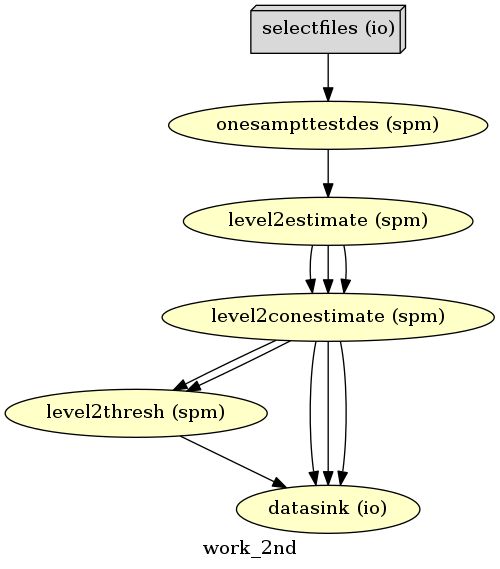

In [112]:
# Create 1st-level analysis output graph
analysis2nd.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename='/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/graph.png')

##  Run the Workflow

Now that everything is ready, we can run the 2nd-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [113]:
analysis2nd.run('MultiProc', plugin_args={'n_procs': 4})

211108-12:26:42,345 nipype.workflow INFO:
	 Workflow work_2nd settings: ['check', 'execution', 'logging', 'monitoring']
211108-12:26:42,450 nipype.workflow INFO:
	 Running in parallel.
211108-12:26:42,452 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211108-12:26:42,545 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0009/selectfiles".
211108-12:26:42,546 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0008/selectfiles".
211108-12:26:42,547 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0007/selectfiles".
211108-12:26:42,549 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211108-12:26:49,926 nipype.workflow INFO:
	 [Node] Finished "work_2nd.onesampttestdes".
211108-12:26:50,462 nipype.workflow INFO:
	 [Job 1] Completed (work_2nd.onesampttestdes).
211108-12:26:50,467 nipype.workflow INFO:
	 [Job 7] Completed (work_2nd.onesampttestdes).
211108-12:26:50,472 nipype.workflow INFO:
	 [Job 13] Completed (work_2nd.onesampttestdes).
211108-12:26:50,478 nipype.workflow INFO:
	 [Job 19] Completed (work_2nd.onesampttestdes).
211108-12:26:50,480 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211108-12:26:50,543 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0009/level2estimate".
211108-12:26:50,545 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0008/level2estimate".
211108-12:26:50,546 nipype.workflow INFO:
	 [Node]

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211108-12:26:57,829 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2estimate".
211108-12:26:57,839 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2estimate".


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211108-12:26:58,468 nipype.workflow INFO:
	 [Job 2] Completed (work_2nd.level2estimate).
211108-12:26:58,469 nipype.workflow INFO:
	 [Job 8] Completed (work_2nd.level2estimate).
211108-12:26:58,470 nipype.workflow INFO:
	 [Job 14] Completed (work_2nd.level2estimate).
211108-12:26:58,470 nipype.workflow INFO:
	 [Job 20] Completed (work_2nd.level2estimate).
211108-12:26:58,472 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211108-12:26:58,534 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0009/level2conestimate".
211108-12:26:58,535 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0008/level2conestimate".
211108-12:26:58,537 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211108-12:27:04,890 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2conestimate".
211108-12:27:04,943 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2conestimate".


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211108-12:27:06,476 nipype.workflow INFO:
	 [Job 3] Completed (work_2nd.level2conestimate).
211108-12:27:06,477 nipype.workflow INFO:
	 [Job 9] Completed (work_2nd.level2conestimate).
211108-12:27:06,478 nipype.workflow INFO:
	 [Job 15] Completed (work_2nd.level2conestimate).
211108-12:27:06,479 nipype.workflow INFO:
	 [Job 21] Completed (work_2nd.level2conestimate).
211108-12:27:06,480 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211108-12:27:06,543 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0009/level2thresh".
211108-12:27:06,544 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0008/level2thresh".
211108-12:27:06,546 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/w

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211108-12:27:10,482 nipype.workflow INFO:
	 [Job 4] Completed (work_2nd.level2thresh).
211108-12:27:10,487 nipype.workflow INFO:
	 [Job 10] Completed (work_2nd.level2thresh).
211108-12:27:10,491 nipype.workflow INFO:
	 [Job 16] Completed (work_2nd.level2thresh).
211108-12:27:10,494 nipype.workflow INFO:
	 [Job 22] Completed (work_2nd.level2thresh).
211108-12:27:10,496 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211108-12:27:10,579 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0009/datasink".
211108-12:27:10,581 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0008/datasink".
211108-12:27:10,583 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0007/datasink".
211108

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211108-12:27:20,493 nipype.workflow INFO:
	 [Job 25] Completed (work_2nd.onesampttestdes).
211108-12:27:20,498 nipype.workflow INFO:
	 [Job 31] Completed (work_2nd.onesampttestdes).
211108-12:27:20,503 nipype.workflow INFO:
	 [Job 37] Completed (work_2nd.onesampttestdes).
211108-12:27:20,509 nipype.workflow INFO:
	 [Job 43] Completed (work_2nd.onesampttestdes).
211108-12:27:20,515 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211108-12:27:20,577 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0005/level2estimate".
211108-12:27:20,578 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0004/level2estimate".
211108-12:27:20,580 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_d

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211108-12:27:27,456 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2estimate".
211108-12:27:27,456 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2estimate".


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211108-12:27:28,501 nipype.workflow INFO:
	 [Job 26] Completed (work_2nd.level2estimate).
211108-12:27:28,505 nipype.workflow INFO:
	 [Job 32] Completed (work_2nd.level2estimate).
211108-12:27:28,512 nipype.workflow INFO:
	 [Job 38] Completed (work_2nd.level2estimate).
211108-12:27:28,516 nipype.workflow INFO:
	 [Job 44] Completed (work_2nd.level2estimate).
211108-12:27:28,518 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211108-12:27:28,581 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0005/level2conestimate".
211108-12:27:28,583 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0004/level2conestimate".
211108-12:27:28,584 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2conestimate" in "/home/neuro/Result/Nipype_tutoria

stty: 'standard input': Inappropriate ioctl for device


211108-12:27:35,69 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2conestimate".
211108-12:27:35,69 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2conestimate".
211108-12:27:35,90 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2conestimate".


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211108-12:27:36,507 nipype.workflow INFO:
	 [Job 27] Completed (work_2nd.level2conestimate).
211108-12:27:36,508 nipype.workflow INFO:
	 [Job 33] Completed (work_2nd.level2conestimate).
211108-12:27:36,509 nipype.workflow INFO:
	 [Job 39] Completed (work_2nd.level2conestimate).
211108-12:27:36,511 nipype.workflow INFO:
	 [Job 45] Completed (work_2nd.level2conestimate).
211108-12:27:36,512 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211108-12:27:36,573 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0005/level2thresh".
211108-12:27:36,574 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0004/level2thresh".
211108-12:27:36,576 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211108-12:27:40,512 nipype.workflow INFO:
	 [Job 28] Completed (work_2nd.level2thresh).
211108-12:27:40,516 nipype.workflow INFO:
	 [Job 34] Completed (work_2nd.level2thresh).
211108-12:27:40,519 nipype.workflow INFO:
	 [Job 40] Completed (work_2nd.level2thresh).
211108-12:27:40,526 nipype.workflow INFO:
	 [Job 46] Completed (work_2nd.level2thresh).
211108-12:27:40,527 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211108-12:27:40,591 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0005/datasink".
211108-12:27:40,593 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0004/datasink".
211108-12:27:40,595 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0003/datasink".
21110

stty: 'standard input': Inappropriate ioctl for device


211108-12:27:50,520 nipype.workflow INFO:
	 [Job 49] Completed (work_2nd.onesampttestdes).
211108-12:27:50,521 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211108-12:27:50,581 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0001/level2estimate".
211108-12:27:50,616 nipype.workflow INFO:
	 [Node] Running "level2estimate" ("nipype.interfaces.spm.model.EstimateModel")
211108-12:27:52,522 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * work_2nd.level2estimate
211108-12:27:56,481 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2estimate".
211108-12:27:56,526 nipype.workflow INFO:
	 [Job 50] Completed (work_2nd.level2estimate).
211108-12:27:56,528 nipype.workflow INFO:
	 [MultiProc] Ru

stty: 'standard input': Inappropriate ioctl for device


211108-12:27:58,529 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * work_2nd.level2conestimate
211108-12:28:02,223 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2conestimate".


stty: 'standard input': Inappropriate ioctl for device


211108-12:28:02,533 nipype.workflow INFO:
	 [Job 51] Completed (work_2nd.level2conestimate).
211108-12:28:02,534 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211108-12:28:02,595 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0001/level2thresh".
211108-12:28:02,638 nipype.workflow INFO:
	 [Node] Running "level2thresh" ("nipype.interfaces.spm.model.Threshold")
211108-12:28:04,480 nipype.workflow INFO:
	 [Node] Finished "work_2nd.level2thresh".
211108-12:28:04,537 nipype.workflow INFO:
	 [Job 52] Completed (work_2nd.level2thresh).
211108-12:28:04,543 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211108-12:28:04,612 nipype.workflow INFO:
	 [Node] Setting-up "work_2nd.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/work_2nd/_cont_id_0001/dat

stty: 'standard input': Inappropriate ioctl for device


211108-12:28:04,657 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/2ndLevel/_cont_id_0001/spmT_0001.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/2ndLevel/con_0001/spmT_0001.nii
211108-12:28:04,663 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/2ndLevel/_cont_id_0001/con_0001.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/2ndLevel/con_0001/con_0001.nii
211108-12:28:04,669 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/2ndLevel/_cont_id_0001/spmT_0001_thr.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/2ndLevel/con_0001/spmT_0001_thr.nii
211108-12:28:04,698 nipype.workflow INFO:
	 [Node] Finished "work_2nd.datasink".
211108-12:28:06,539 nipype.workflow INFO:
	 [Job 53] Completed (work_2nd.datasink).
211108-12:28:06,546 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 

# Visualize results

Let's take a look at the results. Keep in mind that we only have *`N=6`* subjects and that we set the voxel threshold to a very liberal `p<0.01`. Interpretation of the results should, therefore, be taken with a lot of caution.

In [114]:
from nilearn.plotting import plot_glass_brain
%matplotlib inline
out_path = '/home/neuro/Result/Nipype_tutorial/working_dir/datasink_handson/2ndLevel/'

/opt/miniconda-latest/envs/neuro/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


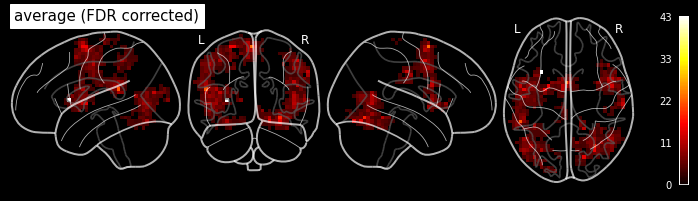

In [115]:
plot_glass_brain(out_path + 'con_0001/spmT_0001_thr.nii', display_mode='lyrz',
                 black_bg=True, colorbar=True, title='average (FDR corrected)');

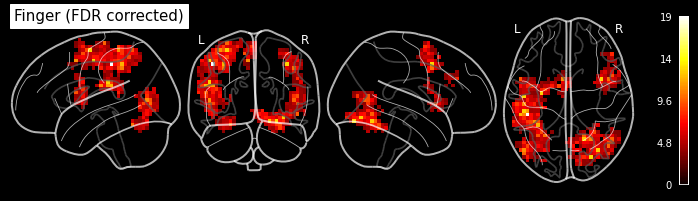

In [116]:
plot_glass_brain(out_path + 'con_0002/spmT_0001_thr.nii', display_mode='lyrz',
                 black_bg=True, colorbar=True, title='Finger (FDR corrected)');

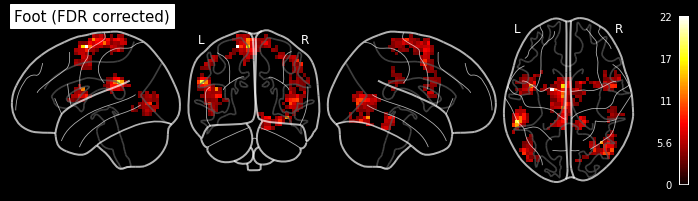

In [117]:
plot_glass_brain(out_path + 'con_0003/spmT_0001_thr.nii', display_mode='lyrz',
                 black_bg=True, colorbar=True, title='Foot (FDR corrected)');

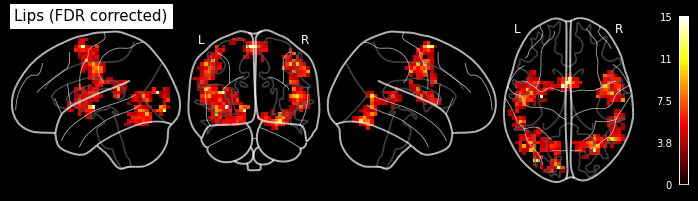

In [118]:
plot_glass_brain(out_path + 'con_0004/spmT_0001_thr.nii', display_mode='lyrz',
                 black_bg=True, colorbar=True, title='Lips (FDR corrected)');

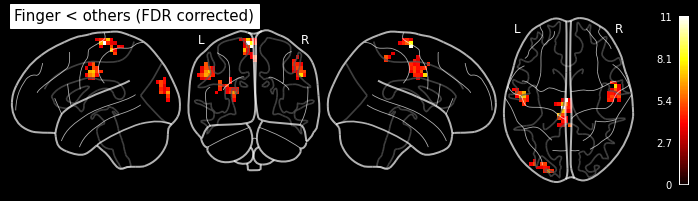

In [119]:
plot_glass_brain(out_path + 'con_0005/spmT_0001_thr.nii', display_mode='lyrz',
                 black_bg=True, colorbar=True, title='Finger < others (FDR corrected)');

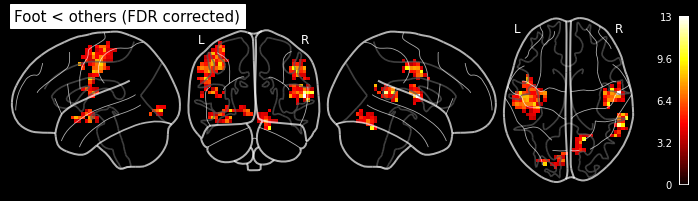

In [120]:
plot_glass_brain(out_path + 'con_0006/spmT_0001_thr.nii', display_mode='lyrz',
                 black_bg=True, colorbar=True, title='Foot < others (FDR corrected)');

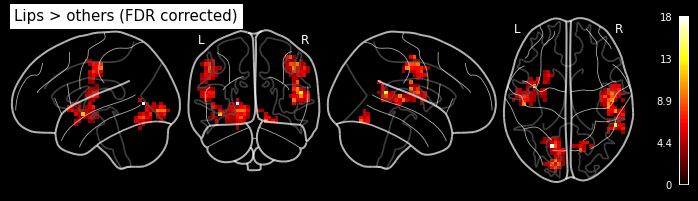

In [121]:
plot_glass_brain(out_path + 'con_0007/spmT_0001_thr.nii', display_mode='lyrz',
                 black_bg=True, colorbar=True, title='Lips > others (FDR corrected)');